In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import pandas_ta as pa


In [5]:
company = '^NSEI'

start = '2020-01-01'
end = '2023-01-01'


data = yf.download(company, start=start, end=end)
data.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'}, inplace= True)
data

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,Adj Close,volume
Date,,,,,,
2020-01-01,12202.150391,12222.200195,12165.299805,12182.500000,12182.500000,304100
2020-01-02,12198.549805,12289.900391,12195.250000,12282.200195,12282.200195,407700
2020-01-03,12261.099609,12265.599609,12191.349609,12226.650391,12226.650391,428800
2020-01-06,12170.599609,12179.099609,11974.200195,11993.049805,11993.049805,396500
2020-01-07,12079.099609,12152.150391,12005.349609,12052.950195,12052.950195,447800
...,...,...,...,...,...,...
2022-12-26,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700
2022-12-27,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300
2022-12-28,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900


In [6]:
df=data

df['RSI'] = pa.rsi(df.close, length=16)
df['CCI'] = pa.cci(df.high, df.low, df.close, length=16)
df['AO'] = pa.ao(df.high,df.low)
df['MOM'] = pa.mom(df.close,length=16)

a = pa.macd(df.close)
df = df.join(a)

df['ATR'] = pa.atr(df.high, df.low,df.close, length=16)
df['BOP'] = pa.bop(df.open, df.high, df.low, df.close, length=16)
df['RVI'] = pa.rvi(df.close)

a = pa.dm(df.high, df.low, length=16)
df = df.join(a)

a = pa.stoch(df.high, df.low, df.close)
df = df.join(a)

a = pa.stochrsi(df.close, length=16)
df = df.join(a)

df["WPR"] = pa.willr(df.high, df.low, df.close, length=16)


In [8]:

df.isna().sum()
df.dropna(inplace=True)
df.isna().sum()
df.reset_index(inplace=True, drop=True)
df.tail()

,open,high,low,close,Adj Close,volume,RSI,CCI,AO,MOM,...,ATR,BOP,RVI,DMP_16,DMN_16,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,WPR
708,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700,42.183902,-155.947621,-273.546507,-681.500000,...,202.438792,0.594479,42.445392,31.313007,61.206037,12.650847,10.793463,7.828190,4.385000,-74.815350
709,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300,45.782492,-97.671949,-318.261058,-568.750000,...,201.148916,0.233772,52.711923,33.427843,57.380660,22.630501,13.732718,20.772458,9.533549,-61.159523
710,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900,45.530783,-74.113601,-360.210645,-520.250000,...,195.123984,0.360382,43.951016,32.829204,53.794368,34.230109,23.170486,34.444808,21.015152,-62.222688
711,18045.699219,18229.699219,17992.800781,18191.000000,18191.000000,281100,47.675460,-59.459864,-370.825747,-369.500000,...,197.734887,0.613346,52.791443,30.777379,55.154022,40.608604,32.489738,43.075136,32.764134,-54.791975
712,18259.099609,18265.250000,18080.300781,18105.300781,18105.300781,192000,45.295442,-47.455566,-313.893549,-504.048828,...,196.935783,-0.831573,44.814703,31.075716,51.706896,39.632306,38.157007,43.589616,40.369853,-64.088418


In [26]:
#Target flexible way
# Calculates if the trend is an uptrend of a downtrend
pipdiff = 100 #for TP

SLTPRatio = 1 #pipdiff/Ratio gives SL
def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)
        #if ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 2 # bth limits exceeded
        #elif ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 3 #-1 downtrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
        #    trendcat[line] = 1 # uptrend
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 0 # no trend
        #elif ( (valueOpenLow >= (pipdiff/SLTPRatio)) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 5 # light trend down
        #elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= (pipdiff/SLTPRatio)) ):
        #    trendcat[line] = 4 # light trend up
            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

<Axes: >

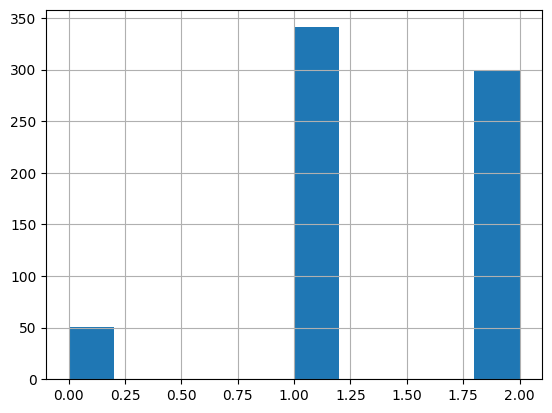

In [27]:
df['Target']=mytarget(20,df)
df['Target'].hist()


In [28]:
df

,open,high,low,close,Adj Close,volume,RSI,CCI,AO,MOM,...,BOP,RVI,DMP_16,DMN_16,STOCHk_14_3_3,STOCHd_14_3_3,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,WPR,Target
0,12131.799805,12159.599609,12037.000000,12045.799805,12045.799805,0,46.593186,10.199745,4.702062,-202.450195,...,-0.701470,35.272891,31.957561,41.746977,79.298067,83.529286,83.338369,90.177395,-31.777970,1.0
1,12028.250000,12030.750000,11908.049805,11992.500000,11992.500000,676900,44.460079,-64.249600,-21.949405,-126.500000,...,-0.291361,30.806636,29.709725,47.880692,68.978677,78.190441,72.475194,82.885188,-40.208813,1.0
2,12090.599609,12134.700195,12042.099609,12125.900391,12125.900391,513600,50.508984,32.969805,-37.339838,70.100586,...,0.381216,39.732304,34.891052,44.539044,69.635125,72.637290,74.072976,76.628846,-19.107840,1.0
3,12119.000000,12152.000000,12071.450195,12080.849609,12080.849609,502600,48.602201,35.656088,-48.106029,-48.650391,...,-0.473625,34.688207,33.672225,41.453114,71.483158,70.032320,76.948629,74.498933,-26.233871,1.0
4,12012.549805,12012.549805,11813.400391,11829.400391,11829.400391,490800,39.683201,-112.828692,-94.487084,-206.399414,...,-0.919658,31.121962,31.354938,56.359072,54.862355,65.326879,70.265488,73.762364,-66.007541,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,17830.400391,18084.099609,17774.250000,18014.599609,18014.599609,176700,42.183902,-155.947621,-273.546507,-681.500000,...,0.594479,42.445392,31.313007,61.206037,12.650847,10.793463,7.828190,4.385000,-74.815350,NaN
709,18089.800781,18149.250000,17967.449219,18132.300781,18132.300781,214300,45.782492,-97.671949,-318.261058,-568.750000,...,0.233772,52.711923,33.427843,57.380660,22.630501,13.732718,20.772458,9.533549,-61.159523,NaN
710,18084.750000,18173.099609,18068.349609,18122.500000,18122.500000,193900,45.530783,-74.113601,-360.210645,-520.250000,...,0.360382,43.951016,32.829204,53.794368,34.230109,23.170486,34.444808,21.015152,-62.222688,NaN
711,18045.699219,18229.699219,17992.800781,18191.000000,18191.000000,281100,47.675460,-59.459864,-370.825747,-369.500000,...,0.613346,52.791443,30.777379,55.154022,40.608604,32.489738,43.075136,32.764134,-54.791975,NaN
